In [1]:
import numpy as np
from itertools import count
from matplotlib import pyplot as plt
from copy import copy
from openscm import timeframes

---
# Timeframes

In OpenSCM, a timeframe is simply a starting point in time, plus a period length. This uniquely defines all time points the values in a timeseries correspond to. The class for handling timeframes is `openscm.timesframes.Timeframe`.

## Source timeframe

A source timeframe is the timeframe for our test timeseries:

In [2]:
source = timeframes.Timeframe(
    start_time = 0,
    period_length = 10
)

## Target timeframe

The target timeframe defines the timeframe we want the timeseries to convert to:

In [3]:
target = timeframes.Timeframe(
    start_time = 4,
    period_length = 7
)

## Test values to convert

Let's define the actual test timeseries:

In [4]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])

---
# Point data

Converting point data, i.e. state variables (e.g. temperature, concentrations) is fairly easy using linear interpolation.

## Source timeframe

Given a source timeframe and the number of points we want in our timeseries, we can determine when each of the values in the source data occurs.

In [5]:
source_points = source.get_points(len(source_values))

### Plot

To show this visually, we plot the timeseries at its time points as defined by the source timeframe:

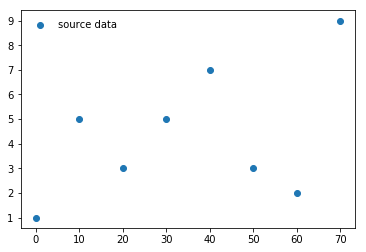

In [6]:
ax = plt.figure().add_subplot(111)
ax.scatter(source_points, source_values, label="source data", marker="o")
ax.legend(frameon=False);

For point data we approximate the "real" data by linearily interpolating between data points.

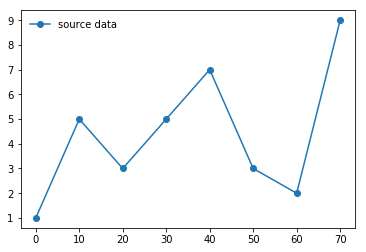

In [7]:
ax = plt.figure().add_subplot(111)
ax.plot(source_points, source_values, label="source data", marker="o")
ax.legend(frameon=False);

## Target timeframe

Given our source values and our target timeframe, we can determine how many points we need in our target timeseries.

In [8]:
source_stop_time = source.get_stop_time(len(source_values))
target_len = target.get_length_until(source_stop_time)
target_points = target.get_points(target_len)

### Plot

We can visualise the points in our target timeseries as shown

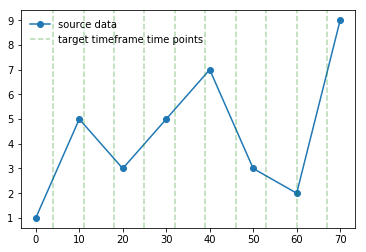

In [9]:
ax = plt.figure().add_subplot(111)
ax.plot(source_points, source_values, label="source data", marker="o")
for i, x in enumerate(target_points):
    ax.axvline(x=x, color="green", alpha=0.3, linestyle="--", label="target timeframe time points" if i == 0 else None)
ax.legend(frameon=False);

## Interpolation

For point data we can in the first order use the linearily interpolated data at the target timeframe edges (this functionality is inbuilt in OpenSCM, we just show the numpy function here for clarity).

In [10]:
target_values = np.interp(target_points, source_points, source_values)

### Plot

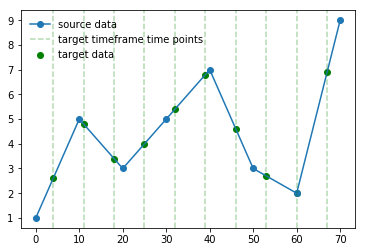

In [11]:
ax = plt.figure().add_subplot(111)
ax.plot(source_points, source_values, label="source data", marker="o")
for i, x in enumerate(target_points):
    ax.axvline(x=x, color="green", alpha=0.3, linestyle="--", label="target timeframe time points" if i == 0 else None)
ax.scatter(target_points, target_values, color="green", label="target data")
ax.legend(frameon=False);

## Result

The result is as shown. As you can see, interpolating the target points gives a timeseries which looks different to the interpolated source points. This is unavoidable given the loss of information that comes from moving point values onto different points in time.

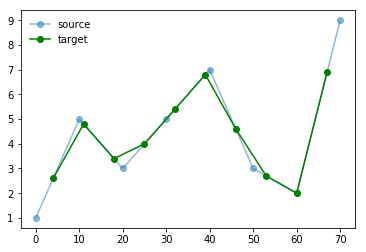

In [12]:
ax = plt.figure().add_subplot(111)
ax.plot(source_points, source_values, label="source", marker="o", alpha=0.5)
ax.plot(target_points, target_values, label="target", marker="o", color="green")
ax.legend(frameon=False);

---
# Period average data

## Input data

Such a timeframe conversion gets more complicated when we want to interpolate not point data but data representing the **averages** for the corresponding periods, e.g. flux variables, as is the standard for OpenSCM. The reason this gets more complicated that we cannot just join midpoints or endpoints as that would result in the wrong averages; we need to preserve the integral over each period. Thus, we use the following procedure to convert period average data between timeframes.

### Plot

In [13]:
def plot_timeframe(ax, values, timeframe, **kwargs):
    ax.step(timeframe.get_points(len(values) + 1), np.concatenate(([values[0]], values)), **kwargs)

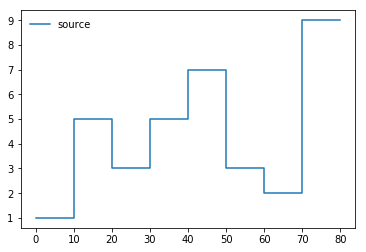

In [14]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source")
ax.legend(frameon=False);

## 1. Linearization

In a first step the data points are interpolated to gain the assumed "real" underlying data such that their average (i.e. integral over the period divided by the period length) equals the original source data. The linearization is based on three points per period. At each period edge the value is assumed to equal the average of the values for the two adjacent periods, at the period mid point the value is adjusted such that the period average equals the original period average (i.e. the original data value for that period). For the first and the last period the mid points are assumed to be at the period average and the outer edges are adjusted accordingly.

In [15]:
linearization_points, linearization_values = timeframes._calc_linearization(source_values, source)

### Plot

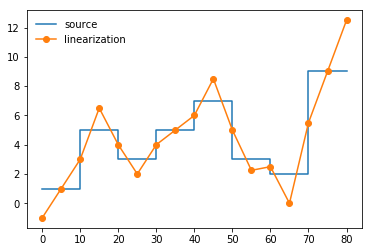

In [16]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source")
ax.plot(linearization_points, linearization_values, label="linearization", marker="o")
ax.legend(frameon=False);

## 2. Interpolation

In a second step, the linearized values are used to determine the values at the edges of the target timeseries (green dots in plot below) as well as at their sampling points (orange dots). This ensures that we retain as much information as possible. We use this information in the next step, when we determine the target timeseries values.

In [17]:
interpolation = timeframes._calc_interpolation_points(
    len(source_values),
    source,
    target
)
interpolation_values = np.interp(
    interpolation.points, linearization_points, linearization_values
)

### Plot

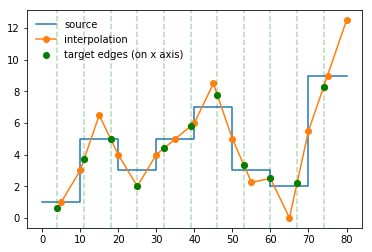

In [18]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source")
ax.plot(interpolation.points, interpolation_values, label="interpolation", marker="o")
ax.scatter(interpolation.points[interpolation.target_indices], interpolation_values[interpolation.target_indices], color="green", zorder=10, label="target edges (on x axis)")
for x in interpolation.points[interpolation.target_indices]:
    ax.axvline(x=x, color="green", alpha=0.3, ls="--")
ax.legend(frameon=False);

## 3. Average over intervals

To gain the target timeframe values the integral over the target time period divided by the period length is taken. For the first and last period this is only done only over the available data points (divided by the length of available data).

In [19]:
interval_averages = timeframes._calc_interval_averages(
    interpolation,
    interpolation_values
)

### Plot

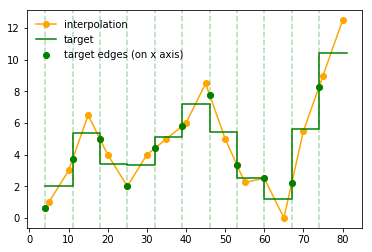

In [20]:
ax = plt.figure().add_subplot(111)
ax.plot(interpolation.points, interpolation_values, label="interpolation", marker="o", color="orange")
ax.scatter(interpolation.points[interpolation.target_indices], interpolation_values[interpolation.target_indices], color="green", zorder=10, label="target edges (on x axis)")
plot_timeframe(ax, interval_averages, target, label="target", color="green")
for x in interpolation.points[interpolation.target_indices]:
    ax.axvline(x=x, color="green", alpha=0.3, ls="--")
ax.legend(frameon=False);

## Result

The `timeframes._convert` function is used by `timeframes.TimeframeConverter`, which is also responsible for caching (e.g. the interpolation points).

In [21]:
target_values = timeframes._convert(source_values, source, target)

### Plot

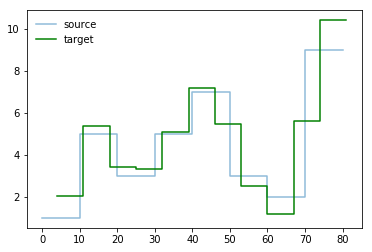

In [22]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source", alpha=0.5)
plot_timeframe(ax, target_values, target, label="target", color="green")
ax.legend(frameon=False);

## Converting to the same timeframe 

Converting from source timeframe to source timeframe does not alter data - as we expect.

In [23]:
target_values = timeframes._convert(source_values, source, source)
np.testing.assert_array_equal(target_values, source_values)

### Plot

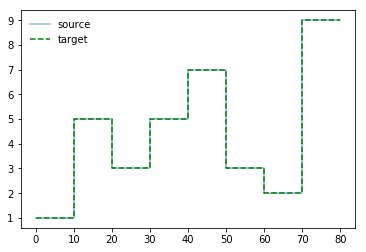

In [24]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source", alpha=0.5)
plot_timeframe(ax, target_values, source, label="target", color="green", linestyle="--")
ax.legend(frameon=False);

## Converting back and forth

Depending on the target timeframe converting might lose some information and converting back and forth doesn't necessarily lead to the original source (but converting to the same timeframe yields the same). This is because of possibly larger period lengths, overlapping of periods (both leading to averages taken over several data points possibly losing their information), and chopped-off information at the beginning and the end of the timeseries for shifted periods.

In [25]:
target_values = timeframes._convert(source_values, source, target)
back_converted = timeframes._convert(target_values, target, source)

### Plot

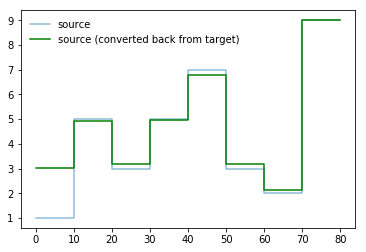

In [26]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source, label="source", alpha=0.5)
plot_timeframe(ax, back_converted, source, label="source (converted back from target)", color="green")
ax.legend(frameon=False);